In [10]:
import graspy
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import numpy as np
from graspy.simulations import sbm
%matplotlib inline

# In the "error" story, there are two considerations. 1) Estimation of model parameters when class membership is known, 2) Estimation of model parameters when class membship is not known



def choose(n, k):
    return np.math.factorial(n) / (np.math.factorial(n - k)*np.math.factorial(k))

def blowup(P, tau):
    n = len(tau)
    unique_labels = np.unique(tau)
    
    new_tau = -1*np.ones(n).astype(int)
    for i in range(n):
        new_tau[i] = int(np.where(tau[i]==unique_labels)[0][0])
    blown_up = np.zeros((n, n))
    
    for i in range(n):
        temp_label1 = new_tau[i]
        for j in range(i+1, n):
            temp_label2 = new_tau[j]
            blown_up[i,j] = P[new_tau[i], new_tau[j]]
            blown_up[j,i] = P[new_tau[j], new_tau[i]]
            
    return blown_up

def estimate_P(G, tau=None):
    if tau is None:
        return (np.sum(G)/2)/choose(n,2)
    
    n = len(tau)
    unique_labels, label_counts = np.unique(tau, return_counts=True)
    
    K = len(unique_labels)
    
    counts = np.zeros((K,K))
    for i in range(n):
        temp1=tau[i]
        for j in range(i+1, n):
            temp2=tau[j]
            counts[temp1,temp2]+=G[i,j]
    p_hat = np.zeros(counts.shape)
    for k in range(K):
        p_hat[k,k] = counts[k,k] / choose(label_counts[k], 2)
        for j in range(k+1, K):
            p_hat[k,j] = counts[k,j]/(label_counts[j]*label_counts[k])
            p_hat[j,k]=p_hat[k,j]
            
    return p_hat

np.random.seed(2)
MCs=20
n=100
pi0=0.5

P = np.array([
    [0.3, 0.3],
     [0.3, 0.3]
])

cs = np.arange(0, 0.7, 0.1)

sbms = [[] for _ in cs]
sbms_unknown = [[] for _ in cs]
sbms_NS = [[] for _ in cs]
ers = [[] for _ in cs]

for i, c in enumerate(tqdm(cs)):
    for _ in range(MCs):
        
        # Not conditioning on the number of nodes in each block
        S=int(np.random.binomial(n, pi0))
        ns = [S, n - S]
        
        # Block membership vector
        tau = np.concatenate((np.zeros(S), np.ones(n -S))).astype(int)
        
        # Probability matrix for this iteration
        temp_P = P + np.diag(c*np.ones(len(ns)))
        temp_P_blownup = blowup(temp_P, tau)

        # Generate adjacency matrix
        G = sbm(n=ns, p=temp_P)

        # Estimate p
        p_hat = (np.sum(G)/2)/choose(n,2)
        
        # Or p_hat * np.ones(shape=(n,n))
        ER_estimate=blowup(p_hat*np.ones(temp_P.shape), tau)
        
        # Error should depend on the number of nodes
        ER_error = np.linalg.norm(ER_estimate - temp_P_blownup)**2
        ers[i].append(ER_error)
        
        # First calculate the error for non spectral methods (only possible when tau known)
        Phat = estimate_P(G, tau)
        NS_estimate = blowup(Phat, tau)
        NS_error = np.linalg.norm(NS_estimate - temp_P_blownup)**2
        sbms_NS[i].append(NS_error)
        
        # Then the error for spectral method when block membership is known
        ase = graspy.embed.AdjacencySpectralEmbed()
        X_hat = ase.fit_transform(G)
        means = np.array([np.mean(X_hat[range(S)], axis=0), np.mean(X_hat[range(S, n)], axis=0)])
        SBM = means @ means.T
        SBM_estimate = blowup(SBM, tau)
        SBM_error = np.linalg.norm(SBM_estimate - temp_P_blownup)**2
        sbms[i].append(SBM_error)

        # Finally, the error for spectral method when block membership is not known
        # This requires first estimating block membership (i used gmm)
        gmm = graspy.cluster.GaussianCluster(max_components=2, min_components=2, covariance_type='full')
        gmm.fit(X_hat)
        estimated_tau1 = gmm.predict(X_hat)
        estimated_tau2 = 1 - estimated_tau1
        means_unknown = gmm.model_.means_
        
        SBM_unknown = means_unknown @ means_unknown.T
        SBM_estimate_unknown1 = blowup(SBM_unknown, estimated_tau1)
        SBM_estimate_unknown2 = blowup(SBM_unknown, estimated_tau2)
        
        SBM_error_unknown1 = np.linalg.norm(SBM_estimate_unknown1 - temp_P_blownup)**2
        SBM_error_unknown2 = np.linalg.norm(SBM_estimate_unknown2 - temp_P_blownup)**2
        sbms_unknown[i].append(min(SBM_error_unknown1, SBM_error_unknown2))

means @ means.T

er_means = np.array([np.mean(e) for e in ers])/n**2
sbm_ns_means = np.array([np.mean(s) for s in sbms_NS])/n**2
sbm_means = np.array([np.mean(s) for s in sbms])/n**2
sbm_unknown_means = np.array([np.mean(s) for s in sbms_unknown])/n**2

er_stderr = [np.std(e, ddof=1) for e in ers]/np.sqrt(MCs)
sbm_stderr = [np.std(s, ddof=1) for s in sbms]/np.sqrt(MCs)
sbm_ns_means = [np.std(s, ddof=1) for s in sbms_NS]/np.sqrt(MCs)
sbm_unknown_means = [np.std(s, ddof=1) for s in sbms_unknown]/np.sqrt(MCs)

fig, ax = plt.subplots(1,1)
ax.plot(cs, er_means, c = 'b', label = 'ER')
ax.plot(cs, sbm_ns_means, c = 'g', label = 'SBM non-spectral')
ax.plot(cs, sbm_means, c='r', label = 'SBM spectral')
ax.plot(cs, sbm_unknown_means, c = 'c', label='SBM unknown blocks')
# ax.fill_between(cs, 
#                 er_means + 1.96*er_stderr,
#                 er_means - 1.96*er_stderr,
#                 where=er_means + 1.96*er_stderr >= er_means - 1.96*er_stderr, 
#                 facecolor='b', 
#                 alpha=0.15,
#                 interpolate=True)
# ax.fill_between(cs, 
#                 sbm_means + 1.96*sbm_stderr,
#                 sbm_means - 1.96*sbm_stderr,
#                 where=sbm_means + 1.96*sbm_stderr >= sbm_means - 1.96*sbm_stderr, 
#                 facecolor='r', 
#                 alpha=0.15,
#                 interpolate=True)
ax.set_ylabel('estimated MSE')
ax.set_xlabel('e')
ax.set_title('initial MSE comparison ')
ax.legend()
plt.savefig('initial_MSE_comparison.png')

ValueError: min_components must be strictly smaller than max_components.

In [4]:
def adj_matrix(n, pi, Lambda, weighted = False, dist = "", means = [], scales = 0, acorn = None):
    if acorn is None:
        acorn=np.random.randint(10**6)
    np.random.seed(acorn)
    n = int(n) # Just in case!
    A = np.zeros(shape = (n, n)) # n x n adjcacency matrix
    K = len(pi) # extract the number of blocks in the SBM

    for i in range(K):
        for j in range(i, K):
            if Lambda[i, j] < 0:
                Lambda[i,j] = 0
            elif Lambda[i, j] > 1:
                Lambda[i, j] = 1
            
    
    i = 0 # start at block indexed with 0
    while i < K: # while the block number is less than the total number of blocks
        for k in range(int(round(n*(sum(pi[:i])))), int(round(n*(sum(pi[:i + 1]))))): # for all vertices in block i
            c = i # start at block i
            while c < K: # while the block number is less than the total number of blocks
                for j in range(int(round(n*(sum(pi[:c])))), int(round(n*(sum(pi[:c + 1]))))): # for all vertices in block c
                    A[k, j] = np.random.binomial(1, Lambda[i, c]) # generates and assigns an edge based on block membership
                    if weighted:
                        if dist == "poisson":
                            A[k, j] = A[k, j] * (np.random.poisson(means[i, c]) + 1)
                        elif dist == "normal":
                        	if type(scales) is int:
                        		A[k, j] = A[k, j] * (np.random.normal(means[i, c], scales))
                        	else:
                        		A[k, j] = A[k, j] * (np.random.normal(means[i, c], scales[i, c]))
                    A[j, k] = A[k, j] # A is symmetric
                c += 1
            A[k,k] = 0 # A is hollow
        i += 1
        
    return A # returns an n x n, symmetric and hollow matrix where A[i,j] in {0, 1}

In [12]:
from tqdm import tqdm
import numpy as np
P = np.array([[0.7, 0.2], [0.2, 0.5]])

ns = np.arange(100, 1000, step =100)

hayden = []
graspy = []

for i, n in enumerate(tqdm(ns)):
    
    start_graspy = time.time()
    A = sbm(np.array([n/2, n/2]).astype(int), P)
    end_graspy = time.time()
    
    graspy.append(end_graspy - start_graspy)
    
    start_hayden = time.time()
    A = adj_matrix(n, [0.5, 0.5], P)
    end_hayden = time.time()
    
    hayden.append(end_hayden - start_hayden)


100%|██████████| 9/9 [00:03<00:00,  1.40it/s]

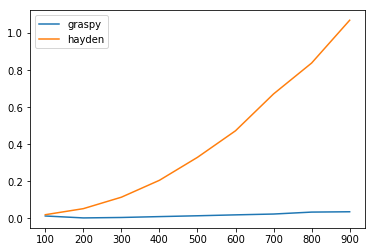

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1,1)
ax.plot(ns, graspy, label = 'graspy')
ax.plot(ns, hayden, label = 'hayden')
ax.legend()